In [46]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
import math 
import argparse
import yaml

In [6]:
class Vaga:
    def __init__(self, x1, y1, x2, y2 ):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def click_and_crop(event, x, y, flags, param):
    # grab references to the global variables
    global refPt, cropping
 
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        cropping = True
 
    # check to see if the left mouse button was released
    elif event == cv2.EVENT_LBUTTONUP:
        # record the ending (x, y) coordinates and indicate that
        # the cropping operation is finished
        refPt.append((x, y))
        cropping = False 
        
        v = Vaga(refPt[0][0], refPt[0][1], refPt[1][0], refPt[1][1] )
        vagas.append(v)
        cv2.rectangle(image, refPt[0], refPt[1], (0, 255, 0), 2)
        clone = image.copy()
        #roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
        #cv2.imshow("image", img)
        #cv2.imshow("ROI", roi)

        # draw a rectangle around the region of interest


# Resize Imagem de Acordo de Dimensões de Video

In [2]:

#nomeVideo = "img/parking_lot_1.mp4"
nomeVideo = "img/parking_ifma_480p.mp4"
cap = cv2.VideoCapture(nomeVideo)

#Pega informações do video
width =int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

nomeImageParaPegarPosicao = "img/5.png"
image = cv2.imread(nomeImageParaPegarPosicao) 
imagemPosicaoResized = cv2.resize(image,(width,height))
imagemPosicaoResized.shape

(480, 854, 3)

# Definir Vagas

In [17]:
# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
refPt = []
vagas = []
cropping = False

# load the image, clone it, and setup the mouse callback function
image = imagemPosicaoResized.copy()
 
clone = image.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)
 
# keep looping until the 'q' key is pressed

while True:
    # display the image and wait for a keypress
    cv2.imshow("image", image)
    key = cv2.waitKey(1) & 0xFF
     
    # if the 'r' key is pressed, reset the cropping region
    if key == ord("r"):
        del refPt[-1]
        #image = clone.copy()
 
    # if the 'c' key is pressed, break from the loop
    elif key == ord("c"):
        break
 
    # if there are two reference points, then crop the region of interest
# from teh image and display it
if len(refPt) == 2:
    roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    cv2.imshow("ROI", roi)
    cv2.waitKey(0)
 
    # close all open windows
cv2.destroyAllWindows()
len(vagas)



parking_contours = []
parking_bounding_rects = []
parking_mask = []
for ind in range(0, len(vagas)):
    points = np.array([(vagas[ind].x1, vagas[ind].y1, vagas[ind].x1, vagas[ind].y2)] )
    ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
    rect = cv2.boundingRect(ctr)
    points_shifted = points.copy()
    points_shifted[:,0] = points[:,0] - rect[0] # shift contour to roi
    points_shifted[:,1] = points[:,1] - rect[1]
    parking_contours.append(ctr)
    parking_bounding_rects.append(rect)
    points_shifted = np.array(points_shifted).reshape((-1,1,2)).astype(np.int32)
    mask = cv2.drawContours(np.zeros((rect[3], rect[2]), dtype=np.uint8), points_shifted, contourIdx=-1, color=255, thickness=-1, lineType=cv2.LINE_8)
    mask = mask==255
    parking_mask.append(mask)

parking_status = [False]*len(vagas)
parking_buffer = [None]*len(vagas)

NameError: name 'click_and_crop' is not defined

 # Processando Video

In [17]:
nomeVideo = "img/parking_lot_1.mp4"

#parking_lot_1
videoSaida = "img/output.mp4"
cap = cv2.VideoCapture(nomeVideo)


config = {'save_video': False,
          'text_overlay': True,
          'parking_overlay': True,
          'parking_id_overlay': False,
          'parking_detection': True,
          'min_area_motion_contour': 60,
          'park_sec_to_wait': 3,
          'start_frame': 0} #35000

video_info = {'fps':    cap.get(cv2.CAP_PROP_FPS),
              'width':  int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
              'fourcc': cap.get(cv2.CAP_PROP_FOURCC),
              'num_of_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}

width =int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #Frame Inicial

while(cap.isOpened()):
    spot = 0
    occupied = 0 
         
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0 # Current position of the video file in seconds
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES) # Index of the frame to be decoded/captured next
    ret, frame = cap.read()   
    if ret == False:
        print("Erro de Captura")
        break
         
        
    # Background Subtraction
    frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
    frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
    frame_out = frame.copy()
    
    #parking_detection
    #Registrar no Video Vagas do Estacionamento                    
    for ind in range(0, len(vagas)):
        points = np.array([(vagas[ind].x1, vagas[ind].y1, vagas[ind].x1, vagas[ind].y2)])
        ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
        
        rect = parking_bounding_rects[ind]
        roi_gray = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] # crop roi for faster calculation   
        
        print rect
        print points

        points[:,0] = points[:,0] - rect[0] # shift contour to roi
        points[:,1] = points[:,1] - rect[1]
        
        status = np.std(roi_gray) < 22 and np.mean(roi_gray) > 53
        
        
        # If detected a change in parking status, save the current time
        if status != parking_status[ind] and parking_buffer[ind]==None:
            parking_buffer[ind] = video_cur_pos
        # If status is still different than the one saved and counter is open
        elif status != parking_status[ind] and parking_buffer[ind]!=None:
            if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                parking_status[ind] = status
                parking_buffer[ind] = None
        # If status is still same and counter is open                    
        elif status == parking_status[ind] and parking_buffer[ind]!=None:
            #if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
            parking_buffer[ind] = None                    
        # print(parking_status)
        
        
    if config['parking_overlay']:                    
        for ind in range(0, len(vagas)):
            points = np.array([(vagas[ind].x1, vagas[ind].y1, vagas[ind].x1, vagas[ind].y2)])
            ctr = np.array(points).reshape((-1,1,2)).astype(np.int32)
            points = np.array(points).reshape((-1,1,2)).astype(np.int32)
            if parking_status[ind]: 
                color = (0,255,0)
                spot = spot+1
            else: 
                color = (0,0,255)
                occupied = occupied+1
                
            cv2.drawContours(frame_out, points, contourIdx=-1,
                             color=color, thickness=2, lineType=cv2.LINE_8)
            cv2.drawContours(frame_out,parking_contours[ind],-1,(255,255,0),3)
            
            t1 = (points[0][0][0], int(points[1][0][1])) 
            t2 = (points[0][0][1] ,points[1][0][1] )
            cv2.rectangle(frame_out, t1, t2 , color, 2)
            
            #t1 = (points[0][0][0], int(points[1][0][1]*0.25)) 
            #t2 = (points[0][0][1] ,points[1][0][1] )
            #cv2.rectangle(frame_out, t1, t2 , color, 2)
            
            ##https://stackoverflow.com/questions/45448120/moments-of-many-objects-python-opencv
            ##https://www.learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/
            cx = np.empty([len(ctr), 1])
            cy = np.empty([len(ctr), 1])
            
            for i in range(0,len(ctr)):
                moments = cv2.moments(ctr[i])

                if moments['m00'] != 0:
                    cx[i]= int(moments['m10']/moments['m00'])-3
                    cy[i]= int(moments['m01']/moments['m00'])+3
                    centroid = (cx[i],cy[i])
                else:
                    centroid = (0,0)

            cv2.putText(frame_out, str(ind), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), (centroid[0]-1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), (centroid[0]+1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), (centroid[0]-1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(ind), centroid, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)
            # print 'occupied: ', occupied
            # print 'spot: ', spot

        
    # Draw Overlay
    if config['text_overlay']:
        #cv2.rectangle(frame_out, (1, 5), (280, 90),(255,255,255), 85)
        cv2.rectangle(frame_out, (1, 5), (210, 90),(255,255,255), 100) 
         
        str_on_frame = "Frames: %d/%d" % (video_cur_frame, video_info['num_of_frames'])
        cv2.putText(frame_out, str_on_frame, (5,30), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0,128,255), 2, cv2.LINE_AA)
        str_on_frame = "Livre: %d Ocupado: %d" % (spot, occupied)
        cv2.putText(frame_out, str_on_frame, (5,90), cv2.FONT_HERSHEY_SIMPLEX,
                            0.7, (0,128,255), 2, cv2.LINE_AA)

        
    # Salva the output frame
    if video_cur_frame % 35 == 0: # take every 30 frames
        fourcc = cv2.VideoWriter_fourcc('D','I','V','X')
        out = cv2.VideoWriter(videoSaida, -1, 25, (width, height))
        
    # Display video
    cv2.imshow('Deteccao de Vagas de Estacionamento', frame_out)
    cv2.waitKey(40)
    
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    elif k == ord('c'):
        cv2.imwrite('img/frame%d.jpg' % video_cur_frame, frame_out)
    elif k == ord('j'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame+1000) # jump to frameq
    
   
    
cap.release()
if config['save_video']: out.release()
cv2.destroyAllWindows()    

(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1

(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1

(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1

(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1, 33)
[[359 324 359 356]]
(359, 324, 1

In [23]:
 len(ctr)

2

In [16]:
refPt[0][0], refPt[0][1], refPt[1][0], refPt[1][1] 

(720, 360, 906, 657)

In [17]:
#cv2.line(frame_out,tuple(np.ravel(points[0])), tuple(np.ravel(points[1])),(0,255,0),3)
#cv2.line(img_marcacao,tuple(np.ravel(points[2])), tuple(np.ravel(points[3])),(0,255,0),3)

#cv2.line(img_marcacao,tuple(np.ravel(points[1])), tuple(np.ravel(points[2])),(0,255,0),3)
#cv2.line(img_marcacao,tuple(np.ravel(points[0])), tuple(np.ravel(points[3])),(0,255,0),3) 

In [18]:
im = frame_out.copy()
cv2.drawContours(im,parking_contours[1],-1,(255,255,0),3)
plt.imshow(im)
plt.show()

 

IndexError: list index out of range

In [20]:
 parking_contours[0]

array([[[445, 372]],

       [[445, 671]]], dtype=int32)

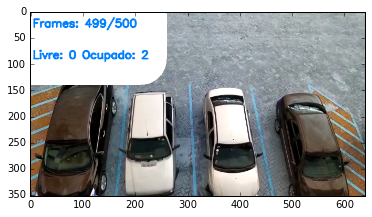

In [29]:
im = frame_out.copy()
x,y,w,h = cv2.boundingRect(parking_contours[0])
cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(im)
plt.show()

In [3]:
nomeVideo = "img/parking_ifma_480p.mp4"
cap = cv2.VideoCapture(nomeVideo)

#Pega informações do video
width =int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

#nomeImageParaPegarPosicao = "img/5.png"
nomeImageParaPegarPosicao = "img/parking_ifma.jpg"

image = cv2.imread(nomeImageParaPegarPosicao) 
imagemPosicaoResized = cv2.resize(image,(width,height))
imagemPosicaoResized.shape

cv2.imwrite("img/resized.png",imagemPosicaoResized)

True

In [4]:
def draw_contours(image,
                  coordinates,
                  label,
                  font_color,
                  border_color= (255,0,0),
                  line_thickness=1,
                  font=cv2.FONT_HERSHEY_SIMPLEX,
                  font_scale=0.5):
    cv2.drawContours(image,
                         [coordinates],
                         contourIdx=-1,
                         color=border_color,
                         thickness=2,
                         lineType=cv2.LINE_8)
    moments = cv2.moments(coordinates)

    center = (int(moments["m10"] / moments["m00"]) - 3,
              int(moments["m01"] / moments["m00"]) + 3)

    cv2.putText(image,
                    label,
                    center,
                    font,
                    font_scale,
                    font_color,
                    line_thickness,
                    cv2.LINE_AA)

In [5]:
class CoordinatesGenerator:
    KEY_RESET = ord("r")
    KEY_QUIT = ord("q")

    def __init__(self, image, output, color):
        self.output = output
        self.caption = image
        self.color = color

        self.image = cv2.imread(image).copy()
        #self.image = image.copy()
        self.click_count = 0
        self.ids = 0
        self.coordinates = []
        # = Cria Janela com dimensões livres
        #cv2.WINDOW_GUI_EXPANDED
        cv2.namedWindow(self.caption, cv2.WINDOW_NORMAL)
        cv2.setMouseCallback(self.caption, self.__mouse_callback)

    def generate(self):
        while True:
            cv2.imshow(self.caption, self.image)
            key = cv2.waitKey(0)

            if key == CoordinatesGenerator.KEY_RESET:
                self.image = self.image.copy()
            elif key == CoordinatesGenerator.KEY_QUIT:
                break
        cv2.destroyWindow(self.caption)

    def __mouse_callback(self, event, x, y, flags, params):

        if event == cv2.EVENT_LBUTTONDOWN:
            self.coordinates.append((x, y))
            self.click_count += 1

            if self.click_count >= 4:
                self.__handle_done()

            elif self.click_count > 1:
                self.__handle_click_progress()

        cv2.imshow(self.caption, self.image)

    def __handle_click_progress(self):
        cv2.line(self.image, self.coordinates[-2], self.coordinates[-1], (255, 0, 0), 1)

    def __handle_done(self):
        cv2.line(self.image,
                     self.coordinates[2],
                     self.coordinates[3],
                     self.color,
                     1)
        cv2.line(self.image,
                     self.coordinates[3],
                     self.coordinates[0],
                     self.color,
                     1)

        self.click_count = 0

        coordinates = np.array(self.coordinates)

        self.output.write("-\n          id: " + str(self.ids) + "\n          coordinates: [" +
                          "[" + str(self.coordinates[0][0]) + "," + str(self.coordinates[0][1]) + "]," +
                          "[" + str(self.coordinates[1][0]) + "," + str(self.coordinates[1][1]) + "]," +
                          "[" + str(self.coordinates[2][0]) + "," + str(self.coordinates[2][1]) + "]," +
                          "[" + str(self.coordinates[3][0]) + "," + str(self.coordinates[3][1]) + "]]\n")

        draw_contours(self.image, coordinates, str(self.ids + 1), (255,255,255))

        for i in range(0, 4):
            self.coordinates.pop()

        self.ids += 1


In [6]:
def parse_args():
    parser = argparse.ArgumentParser(description='Generates Coordinates File')

    parser.add_argument("--image",
                        dest="image_file",
                        required=False,
                        help="Image file to generate coordinates on")

    parser.add_argument("--video",
                        dest="video_file",
                        required=True,
                        help="Video file to detect motion on")

    parser.add_argument("--data",
                        dest="data_file",
                        required=True,
                        help="Data file to be used with OpenCV")

    parser.add_argument("--start-frame",
                        dest="start_frame",
                        required=False,
                        default=1,
                        help="Starting frame on the video")

    return parser.parse_args()

In [7]:
image_file = "img/resized.png"
data_file = "img/file"
#nomeVideo = "img/parking_lot_1.mp4"
nomeVideo = "img/parking_ifma_480p.mp4"
videoSaida = "img/output.mp4"
 


# Obter as coordenadas da Imagem 

In [8]:
if image_file is not None:
    #Coordenadas Salvas Em arquivo .yaml
    with open(data_file, "w+") as points:
            generator = CoordinatesGenerator(image_file, points, (255,0,0))
            generator.generate()
    #Leitura e passagem de Coordenadas para Lista poinnts
    with open(data_file, "r") as data:
        points = yaml.load(data)
 

# Pontos Obtidos

In [9]:
points

[{'coordinates': [[273, 449], [279, 145], [418, 167], [448, 439]], 'id': 0},
 {'coordinates': [[478, 441], [446, 147], [578, 156], [642, 449]], 'id': 1}]

# Vagas Registradas

In [11]:
len(points)

4

# Detecção de Carro

In [11]:
#https://github.com/shaanhk/New-GithubTest/blob/master/cars.xml
#https://www.geeksforgeeks.org/opencv-python-program-vehicle-detection-video-frame
#https://raw.githubusercontent.com/abhi-kumar/CAR-DETECTION/master/cas4.xml

# Classificador de Carros  Treinado com caracteristicas de alguns objetos que queremos identificar (xml)
car_cascade = cv2.CascadeClassifier('cars.xml')   
car_cascade2 = cv2.CascadeClassifier('cas4.xml')  ##Modelo De Classificação Não muito bom

# Processando Video 

In [12]:
config = {'save_video': False,
          'text_overlay': True,
          'parking_overlay': True,
          'parking_id_overlay': False,
          'parking_detection': True,
          'min_area_motion_contour': 60,
          'park_sec_to_wait': 3,
          'start_frame': 0} #35000


carros = []
# Set capture device or file
cap = cv2.VideoCapture(nomeVideo)
# print cap.get(5) 
video_info = {'fps':    cap.get(cv2.CAP_PROP_FPS),
              'width':  int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
              'fourcc': cap.get(cv2.CAP_PROP_FOURCC),
              'num_of_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}
cap.set(cv2.CAP_PROP_POS_FRAMES, config['start_frame']) # jump to frame

# Define the codec and create VideoWriter object
if config['save_video']:
    fourcc = cv2.VideoWriter_fourcc('D','I','V','X')# options: ('P','I','M','1'), ('D','I','V','X'), ('M','J','P','G'), ('X','V','I','D')
    out = cv2.VideoWriter(fn_out, -1, 25.0, #video_info['fps'], 
                          (video_info['width'], video_info['height']))


 #(parking space polygons)
 
parking_data = points
parking_contours = []
parking_bounding_rects = []
parking_mask = []
for park in parking_data:
    points2 = np.array(park['coordinates'])
    rect = cv2.boundingRect(points2)
    points_shifted = points2.copy()
    points_shifted[:,0] = points2[:,0] - rect[0] # shift contour to roi
    points_shifted[:,1] = points2[:,1] - rect[1]
    parking_contours.append(points2)
    parking_bounding_rects.append(rect)
    mask = cv2.drawContours(np.zeros((rect[3], rect[2]), dtype=np.uint8), [points_shifted], contourIdx=-1,
                            color=255, thickness=-1, lineType=cv2.LINE_8)
    mask = mask==255
    parking_mask.append(mask)

parking_status = [False]*len(parking_data)
parking_buffer = [None]*len(parking_data)


while(cap.isOpened()):   
    spot = 0
    occupied = 0 
    # Read frame-by-frame    
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0 # Current position of the video file in seconds
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES) # Index of the frame to be decoded/captured next
    ret, frame = cap.read()    
    if ret == False:
        print("Capture Error")
        break
    
    # frame_gray = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
    # Background Subtraction
    frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
    frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
    frame_out = frame.copy()
    
    cars = car_cascade.detectMultiScale(frame_out, 1.2, 2)
    for (x,y,w,h) in cars: 
        cv2.rectangle(frame_out,(x,y),(x+w,y+h),(0,0,255),2)
        cv2.putText(frame_out,"Carro", (x,y) , cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

            
    
    
    if config['parking_detection']:        
        for ind, park in enumerate(parking_data):
            roi_gray = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] # crop roi for faster calculation   
            # print np.std(roi_gray)
            
            
           
            #print rect
            #print points2
            
            roi_gray_2 = frame_out[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])]
            cars = car_cascade2.detectMultiScale(roi_gray_2, 1.1, 2)
            for (x,y,w,h) in cars: 
                cv2.rectangle(frame_out,(x,y),(x+w,y+h),(0,0,255),2)
                cv2.putText(frame_out,"Carro", (x,y) , cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

            
            points2[:,0] = points2[:,0] - rect[0] # shift contour to roi
            points2[:,1] = points2[:,1] - rect[1]
            
            
            status = np.std(roi_gray) < 22 and np.mean(roi_gray) > 53
            # If detected a change in parking status, save the current time
            if status != parking_status[ind] and parking_buffer[ind]==None:
                parking_buffer[ind] = video_cur_pos
            # If status is still different than the one saved and counter is open
            elif status != parking_status[ind] and parking_buffer[ind]!=None:
                if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                    parking_status[ind] = status
                    parking_buffer[ind] = None
            # If status is still same and counter is open                    
            elif status == parking_status[ind] and parking_buffer[ind]!=None:
                #if video_cur_pos - parking_buffer[ind] > config['park_sec_to_wait']:
                parking_buffer[ind] = None                    
            # print(parking_status)
    if config['parking_overlay']:                    
        for ind, park in enumerate(parking_data):
            points2 = np.array(park['coordinates'])
            if parking_status[ind]: 
                color = (0,255,0)
                spot = spot+1
            else: 
                color = (0,0,255)
                occupied = occupied+1
            
            #rect = parking_bounding_rects[ind]
            #print rect 
           
            cv2.drawContours(frame_out, [points2], contourIdx=-1,
                             color=color, thickness=2, lineType=cv2.LINE_8)            
            moments = cv2.moments(points2)        
            centroid = (int(moments['m10']/moments['m00'])-3, int(moments['m01']/moments['m00'])+3)
            cv2.putText(frame_out, str(park['id']), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]-1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]+1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), (centroid[0]-1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame_out, str(park['id']), centroid, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0), 1, cv2.LINE_AA)

    # Draw Overlay
    if config['text_overlay']:
        cv2.rectangle(frame_out, (1, 5), (280, 90),(255,255,255), 85) 
        str_on_frame = "Frames: %d/%d" % (video_cur_frame, video_info['num_of_frames'])
        cv2.putText(frame_out, str_on_frame, (5,30), cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
                    0.7, (0,128,255), 2, cv2.LINE_AA)
        str_on_frame = "Livre: %d Ocupado: %d" % (spot, occupied)
        cv2.putText(frame_out, str_on_frame, (5,90), cv2.FONT_HERSHEY_SCRIPT_COMPLEX,
                            0.7, (0,128,255), 2, cv2.LINE_AA)
 
            
    # write the output frame
    if config['save_video']:
        if video_cur_frame % 35 == 0: # take every 30 frames
            out.write(frame_out)    
    
    # Display video
    cv2.imshow('Vagas de Estacionamento', frame_out)
    cv2.waitKey(40)
    # cv2.imshow('background mask', bw)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    elif k == ord('c'):
        cv2.imwrite('frame%d.jpg' % video_cur_frame, frame_out)
    elif k == ord('j'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame+1000) # jump to frame


cap.release()
if config['save_video']: out.release()
cv2.destroyAllWindows()    

Capture Error


In [213]:
cars

()

In [177]:

test = frame_out.copy()
cars = car_cascade.detectMultiScale(test , 1.1, 2) 
for (x,y,w,h) in cars: 
        cv2.rectangle(test,(x,y),(x+w,y+h),(0,0,255),2)
        cv2.putText(test,"Carro", (x,y) , cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

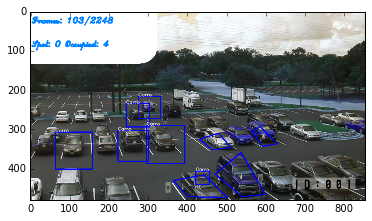

In [178]:
plt.imshow(test)
plt.show()

In [120]:
len(cars)

5

In [124]:
 carros

[(),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),


In [90]:
points2

array([[170, 446],
       [174, 472],
       [251, 471],
       [242, 433]])

In [102]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [116]:

cars

()

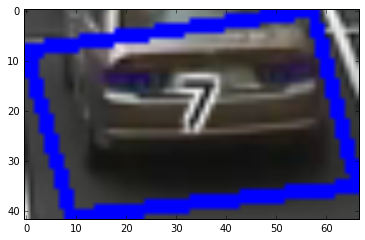

In [135]:
plt.imshow(roi_2)
plt.show()

In [ ]:
moments = cv2.moments(points2)        
centroid = (int(moments['m10']/moments['m00'])-3, int(moments['m01']/moments['m00'])+3)
cv2.putText(frame_out, str(park['id']), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

In [208]:
cars = car_cascade.detectMultiScale2(roi_gray_2 , 1.1, 2) 

In [209]:
cars

((), ())

In [147]:
area = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] 

In [150]:
roi_gray = frame_out[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] 

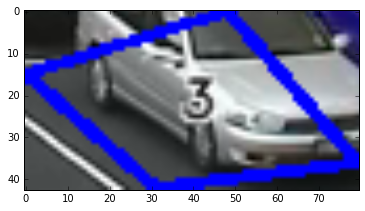

In [183]:
plt.imshow(roi_gray_2, cmap= "gray")
plt.show()

In [182]:
roi_gray_2 = frame_out[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])]


In [1]:
import tensorflow as tf,sys

In [12]:
image_path= sys.argv[1]
image_path = "/home/levimmartins/tensorflow/tensorflow-for-poets-2/tf_files/espacionamento/busy/20150703_0805_8.jpg"

In [13]:
image_path

'/home/levimmartins/tensorflow/tensorflow-for-poets-2/tf_files/espacionamento/busy/20150703_0805_8.jpg'

In [14]:
image_data = tf.gfile.FastGFile(image_path, 'rb').read()

In [17]:
label_lines = [line.rstrip() for line in tf.gfile.GFile("/tf_files/retrained_labels.txt")]

In [20]:
with tf.gfile.FastGFile("/tf_files/retrained_graph.pb", 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name="")

In [45]:
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
    predictions = sess.run(softmax_tensor,  {'DecodeJpeg/contents:0': image_data})
    
    
    top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
    
    
    for node_id in top_k:
        human_string= label_lines[node_id]
        score = predictions[0][node_id]
        print human_string, score

busy 0.9263266
free 0.073673345


In [43]:
top_k

array([0, 1])

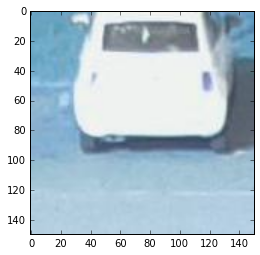

In [50]:
i = cv2.imread("/home/levimmartins/tensorflow/tensorflow-for-poets-2/tf_files/espacionamento/busy/20150703_0805_8.jpg")
plt.imshow(i)
plt.show()

In [39]:
tensor_name_list = [tensor.name for tensor in tf.get_default_graph().as_graph_def().node]
for tensor_name in tensor_name_list:
    print(tensor_name, '\n')

(u'DecodeJpeg/contents', '\n')
(u'DecodeJpeg', '\n')
(u'Cast', '\n')
(u'ExpandDims/dim', '\n')
(u'ExpandDims', '\n')
(u'ResizeBilinear/size', '\n')
(u'ResizeBilinear', '\n')
(u'Sub/y', '\n')
(u'Sub', '\n')
(u'Mul/y', '\n')
(u'Mul', '\n')
(u'conv/conv2d_params', '\n')
(u'conv/Conv2D', '\n')
(u'conv/batchnorm/beta', '\n')
(u'conv/batchnorm/gamma', '\n')
(u'conv/batchnorm/moving_mean', '\n')
(u'conv/batchnorm/moving_variance', '\n')
(u'conv/batchnorm', '\n')
(u'conv/CheckNumerics', '\n')
(u'conv/control_dependency', '\n')
(u'conv', '\n')
(u'conv_1/conv2d_params', '\n')
(u'conv_1/Conv2D', '\n')
(u'conv_1/batchnorm/beta', '\n')
(u'conv_1/batchnorm/gamma', '\n')
(u'conv_1/batchnorm/moving_mean', '\n')
(u'conv_1/batchnorm/moving_variance', '\n')
(u'conv_1/batchnorm', '\n')
(u'conv_1/CheckNumerics', '\n')
(u'conv_1/control_dependency', '\n')
(u'conv_1', '\n')
(u'conv_2/conv2d_params', '\n')
(u'conv_2/Conv2D', '\n')
(u'conv_2/batchnorm/beta', '\n')
(u'conv_2/batchnorm/gamma', '\n')
(u'conv_2/ba

In [51]:
image_data

'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x96\x00\x96\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x06\x05\x07\xff\xc4\x00=\x10\x00\x01\x03\x03\x03\x02\x04\x05\x01\x04\x07\t\x00\x00\x00\x00\x01\x00\x02\x11\x03\x04!\x05\x121AQ\x06\x13\x14a\x07"q\x81\x912#T\x92\xd1\x15\x16RS\x82\xa1\xc1$3BEbr\xa2\xb1\xe1\xff\xc4\x00\x19\x01\x01\x01\x00\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xc4\x00"\x11\x01\x01\x00\x03\x00\x01\x04\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11\x12\x03\x13!"1AQa\x04q\xff\xda\x00\x0c\x03\x01\x00\x0

In [2]:
import base64


encoded_string = base64.b64encode(roi_gray_2)

NameError: name 'roi_gray_2' is not defined